## Kinodata-3D data splits and filtering


### RMSD estimates and filtering
The Kinodata-3D dataset can be associated with a confidence model that estimates the
quality of docked poses in terms of their docking RMSD.

More information regarding the RMSD prediction model and training data is found [here](https://github.com/volkamerlab/kinodata-3D).
The raw data already encodes the precomputed RMSD estimates.

In [1]:
from kinodata.data.dataset import KinodataDocked
import numpy as np
from typing import Literal

dataset = KinodataDocked()

/Users/joschka/mambaforge/envs/kinodata/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predicted_rmsd = dataset.data.predicted_rmsd.numpy()

These predictions contain some outliers that should be filtered or imputed

<AxesSubplot: ylabel='Count'>

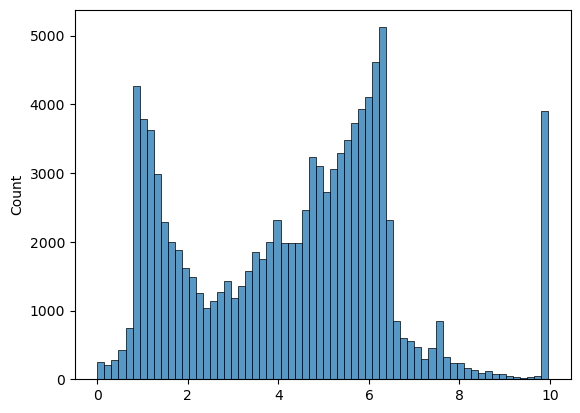

In [3]:
(predicted_rmsd > 20).mean(), (predicted_rmsd < 0).mean()
predicted_rmsd[predicted_rmsd > 10] = predicted_rmsd[predicted_rmsd <= 10].max()
predicted_rmsd[predicted_rmsd < 0] = predicted_rmsd[predicted_rmsd >= 0].min()
import seaborn as sns
sns.histplot(
   x=predicted_rmsd 
)

### Pre-computed splits and preprocessed dataset
The splits used in [the Kinodata-3D publication](https://chemrxiv.org/engage/chemrxiv/article-details/658441f7e9ebbb4db96d98e8) are [available on Zenodo](https://zenodo.org/records/10886085) and
are guaranteed to be compatible with the preprocessed version of the dataset available through the same Zenodo record.

The following code snippet briefly demonstrates how to recreate the data modules we used to train the published models.

In [4]:
from kinodata.data.data_module import make_kinodata_module
import kinodata.configuration as config

data_config = config.get(
    "data",
    "training"
)

The relevant configuration options are
- `filter_rmsd_max_value`, type `float`
- `split_type`, one of `"random-k-fold"`, `"scaffold-k-fold"` or `"pocket-k-fold"`
- `k_fold`, type `int`, number of folds
- `index`, type `int`, determines train/test assignment of folds

In [5]:
split_type: Literal["random-k-fold", "scaffold-k-fold", "pocket-k-fold"] = "random-k-fold"

data_config["filter_rmsd_max_value"] = 2
data_config["split_type"] = split_type
data_config["k_fold"] = 5
data_config["index"] = 0

In [6]:
data_module = make_kinodata_module(data_config)

Creating data module:
    split:Split[int](train=19364, val=2420, test=2421, source=/Users/joschka/projects/kinodata-docked-rescore/data/processed/filter_predicted_rmsd_le2.00/random-k-fold/1:5.csv)
    train_transform:Compose([

])
    val_transform:Compose([

])


In [7]:
batch = next(iter(data_module.train_dataloader()))
print(batch)

HeteroDataBatch(
  kissim_fp=[128, 85, 12],
  y=[128],
  docking_score=[128],
  posit_prob=[128],
  predicted_rmsd=[128],
  pocket_sequence=[128],
  scaffold=[128],
  activity_type=[128],
  ident=[128],
  smiles=[128],
  ligand={
    z=[3997],
    x=[3997, 12],
    pos=[3997, 3],
    batch=[3997],
    ptr=[129]
  },
  pocket={
    z=[84717],
    x=[84717, 12],
    pos=[84717, 3],
    batch=[84717],
    ptr=[129]
  },
  pocket_residue={
    x=[10880, 23],
    batch=[10880],
    ptr=[129]
  },
  (ligand, bond, ligand)={
    edge_index=[2, 8858],
    edge_attr=[8858, 4]
  },
  (pocket, bond, pocket)={
    edge_index=[2, 170756],
    edge_attr=[170756, 4]
  }
)


If you want more control for your own use case, you can also create data splits and data modules separately:

In [8]:
from kinodata.data.grouped_split import KinodataKFoldSplit
from kinodata.data.data_module import make_data_module

# create 5 splits and use the first one
demo_split = KinodataKFoldSplit(split_type, k=5).split(dataset)[0]
# this could take a while, expect ~60 seconds
data_module = make_data_module(
   split=demo_split,
   batch_size=32,
   dataset_cls=KinodataDocked,
   num_workers=0,
   train_kwargs=dict(),
)
demo_batch = next(iter(data_module.train_dataloader()))
demo_batch

HeteroDataBatch(
  kissim_fp=[32, 85, 12],
  y=[32],
  docking_score=[32],
  posit_prob=[32],
  predicted_rmsd=[32],
  pocket_sequence=[32],
  scaffold=[32],
  activity_type=[32],
  ident=[32],
  smiles=[32],
  ligand={
    z=[1000],
    x=[1000, 12],
    pos=[1000, 3],
    batch=[1000],
    ptr=[33]
  },
  pocket={
    z=[21024],
    x=[21024, 12],
    pos=[21024, 3],
    batch=[21024],
    ptr=[33]
  },
  pocket_residue={
    x=[2720, 23],
    batch=[2720],
    ptr=[33]
  },
  (ligand, bond, ligand)={
    edge_index=[2, 2234],
    edge_attr=[2234, 4]
  },
  (pocket, bond, pocket)={
    edge_index=[2, 42412],
    edge_attr=[42412, 4]
  }
)